# Final Project

W261 Machine Learning at Scale<br>
12 December 2018

### Team 5
Wei Wang
Alice Lam
John Tabbone
Noah Randolph

### 1. Question Formulation

Click-Through-Rate (CTR), which defines as "the ratio of users who click on a specific link to the number of total users who view a page, email, or advertisement"$^1$, is a key metric that measure online advertisment performance. It demonstrates both 1) how effective the advertising platforms are, and 2) how effective the advertising campaigns are in targeting the right audience. Since the advertising income is highly correlated with CTR, platforms are motivated to improve their CTR to maximize their revenues. The goal of our analysis is to predict CTR, which can be useful to priortize which ad to show whom in order to maximize advertising revenue.

Online platforms ranging from Google, Facebook, to casual game apps are essentially "online real estate" that draws "traffic", i.e. eyeballs on the screen. They can monetize these traffic by charging businesses advertising fee for putting up ads/links on the screen. Traditionally, the fee is charged per impression, hence termed "CPI - Cost-per-impression". Advertisers would have a campaign budget and a desired return on investment from the budget, e.g. bringing 1 million people to their website with a $\$1,000,000$ budget. If the platform's CTR is 10%, the advertisers can only charge up to $\$0.10$ per impression. If the platform's CTR is 100%, then the maximum CPI could reach $\$1$. Online advertising model has gradually evolved to pay-for-performance, i.e. advertisers would only pay if the link is being clicked. Regardless of the advertising revneue model, platforms are highly incentivized to improve CTR.

Based on the current work in the literature on modeling clicks and CTR, the first challenge is to understand user behaviors. Given the limited opportunity ads can be shown to a specific person at any given time, the platform should present the ads that a person is most likely to click. Understanding browsing and clicking behavior of each individual is thus essential in making CTR prediction for each user. Some of the features that are likely significant for such predictions are: time, day of week, location, gender, age, device they are using, sites they are visiting, sites they came from, topics of the ad, color of the ad, pixel location of the ad on the screen, etc. The data we analyze on was made available by Criteo and contains a portion of Criteo's traffic dataset for 7 days. It has both integer and categorical column of features. However, it is completely anonymiezd which limits us from conducting feature selection or engineering that is backed by contextual understanding.

The second challenge is to optimize algorithm speed, which means the prediction can be done in seconds. For example, given the fact that the person is in this location and launched this app at this time of the day, the algorithm should be able to predict the CTR in split second in order to decide which ad to push to the person. Any accurate prediction delivered too late is almost effectively useless. The algorithm speed is hindered by the great amount of traffic volume that comes into the site, as well as the massive amount of data that has numerous categorical variables with high cardinality. We thus leverage Spark to increase the scalability of our analysis. When selecting models, our priority would be speed over performance.

Another approach to mitigate the speed challenge is to __not__ include information generated from the users from last few seconds/minutes/hours. This approach may be at the cost of accuracy as well because immediate information such as current location, last article the person look at, etc, can enhance accuracy significantly. This is a compromise the platforms need to evalaute given their specific business needs and infrastructure. We have no information on whether some of the features in the dataset is immediate features that's received a few seconds prior to the display of the ad. We choose to assume the features may contain such information.

Throughout this project, we use logistics regression model because as the most prevalent algorithm for solving industry scale problems, it is designed to handle categorical dependent variable (Click vs. Non-Click). Logistics regression has its own drawbacks. As a generalized linear model, it requires transformation for non-linear features. This additional step can slow the process down when the feature space and data volume is too large. However, since the probability score outputs that logistics regression generates are straightforward for observations, and it is not particularly affected by mild cases of multi-collinearity, we decide to combine the power of logistics regression and Spark for our analysis.


$^1$ https://en.wikipedia.org/wiki/Click-through_rate

### 2. **Algorithm Theory**

#### 2.1  Algorithm Overview

##### Motivation

Logistic regression starts with a linear classifier $f(x) = w^Tx + b$ and applies a sigmoid activation function $\sigma$ such that:

$$\sigma(f(x_{i})) =\begin{cases}
+1 & x_{i}\ge .5\\
-1 & x_{i}<.5
\end{cases} $$

and

$$\sigma(f(x))=\frac{1}{1+e^{-f(x)}}
$$

This will 'binarize' the output appropriate to requirements.  

##### Loss Function
To create an accurate model that can estimate the probability of click event occuring $P(y=1|X)$ given training data X, we need to minimize cost function. 

$$
P(y=1|x) = \sigma(f(x)) = \frac{1}{1+e^{-f(x)}}\\  
P(y=-1|x) = 1 - \sigma(f(x)) = \frac{1}{1+e^{f(x)}}  \\   
P(y_{i}|x_{i}) = \frac{1}{1+e^{-y_{i}f(x_{i})}}    \\
$$

The likelihood is the combined product of all these probabilities

$$
\prod_{i}^{n}\frac{1}{1+e^{-y_{i}f(x_{i})}}
$$

We use the negative log liklehood as the loss function:

$$
\sum_{i}^{n} \log(1+e^{-y_{i}f(x_{i})})\\
$$

This is expressed in code in the logLoss() function

    loss = augmentedData.map(lambda p: (np.log(1 + np.exp(-p[1] * np.dot(W, p[0]))))) \
                        .reduce(lambda a, b: a + b)
                        
where<br> 
$y_{i} = p[1]$, and <br>
$f(x) = np.dot(W, p[0])$  

##### Gradient Descent
We use gradient descent to find optimal parameters to minimize the loss function. We find the gradient of the log loss function as:


$$
\nabla w = \sum_{i}^{n} -y\left(1- \frac{1}{1+e^{-y_{i}f(x_{i})}}\right)\cdot x_{i}
$$


Again we can see this formula represented in the code of gdupdate() in the line:

grad = augmentedData.map(lambda p: (-p[1] * (1 - (1 / (1 + np.exp(-p[1] * np.dot(W, p[0]))))) * p[0]))

where<br> 
$y_{i} = p[1]$,<br>
$f(x) = np.dot(W, p[0])$, and<br> 
$x_{i} = p[0]$

##### Iterate
Below, the toy implementation then initializes the first gradient with a random guess.  It will iterate 5 times over the data, upddating the gradient and displaying the error.



  

#### Toy Dataset Illustration

To illustrate our process of implementing a logistic regression model, we create a toy dataset that contains 8 rows of randomly generated data, one categorical dependent variable and four features, to mimic the Criteo dataset. In our toy dataset, dependent values are either 1 or -1, which represent the situation of click vs. non-click. Among the four features, we randomly generate integer values range from 0 to 10 for two numeric feature columns, and randomly picked either 0 or 1 for two categorical feature columns. 

While following the above steps, there are two additional modifications that we make in order to improve model accuracy. The first modification is normalizing feature values, which is not neccessary for the toy dataset but is essential for the entire dataset where high data variance occurs. The formula for normalization is:
\begin{equation}\
x_n= (x - \mu)/\sigma
\end{equation}
where $x_n$ denotes the normalized $x$, $\mu$ denotes the mean of $x$, $\sigma$ denotes the standard deviation of $x$.
<br>

The second modification is to add a bias term to the initial weights that we randomly generated, which eliminates the hassle of multiplying the data point by the weights and then adding the bias.

One additional note is that when predicting on the entire dataset, we convert categorical data using one-hot encoding. This data manipulation process is not shown in this simplified toy dataset illustration.

Our modeling design takes scalability into consideration. We leverage Spark dataframes and RDDs to make the process scale to a larger dataset. 

In [315]:
%%writefile toyDataset.py
#!/usr/bin/env python

import numpy as np
import csv

# Set the seed for random numbers
SEED = 2615

# Number of numeric columns
NUMERIC_COLS = 2
# Number of categorical columns (one hot encoded)
ONE_HOT_COLS = 2


# start Spark Session
from pyspark.sql import SparkSession
app_name = "loadAndEDA"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext


# Creates a toy dataset in the form
# LABEL,INT,INT,CAT,CAT
# where CAT is categorical data that is represented as one hot encoded
# (i.e. 0 or 1)
#
# w:  a list of weights 
# nrows:  The number of rows to produce
def generateToyDataset(w=[8, -3, -1, 3, 8],nrows = 8):
    '''generate toy logistic regression dataset with numerical and 1-hot encoded features'''
        
    # set random number generator
    np.random.seed(SEED)
    
    # These two x vectors represent numeric data
    x1 = np.random.randint(0, 10, nrows)
    x2 = np.random.randint(0, 10, nrows)
    
    # These two represent categorical data that has been
    # one hot encoded
    x3 = np.random.randint(0, 2, nrows) 
    x4 = np.ones(nrows, np.int8) - x3 
    
    # Create an error term for linear function
    noise = np.random.normal(5, 1, nrows)
    
    # Create linear function to determine labels
    v = (w[0] + x1*w[1] + x2*w[2] + x3*w[3] + x4*w[4] + noise)
    
    # Activation function v>0 to determine binary labels 1 and -1
    y = (v>0) * 2 - 1 
    
    # Assemble vectors into single matrix structure
    # NB:  This technique works to assemble the toy dataset but would 
    # be cost prohibitive to perform on a larger dataset
    df = spark.createDataFrame(zip(y.tolist(), x1.tolist(), x2.tolist(), x3.tolist(), x4.tolist()))
 
    # Rename columns from default
    # c1,c2,c3 to human readable
    # Label,I1,I2,C1,C2
    oldColNames = df.columns
    newColNames = ['Label']+['I{}'.format(i) for i in range(0,NUMERIC_COLS)]+['C{}'.format(i) for i in range(0,ONE_HOT_COLS)]
    for oldName, newName in zip(oldColNames, newColNames):
        df = df.withColumnRenamed(oldName, newName)
    return df

# Utility function to change format of RDD
def dfToRDD(row):
    '''
    Converts dataframe row to rdd format.
        From: DataFrame['Label', 'I0', ..., 'C0', ...]
        To:   (features_array, y)
    '''    
    # Create matrix structure of numeric and catageory features
    features_list = [row['I{}'.format(i)] for i in range(0, NUMERIC_COLS)] + [row['C{}'.format(i)] for i in range(0, ONE_HOT_COLS)]
    features_array = np.array(features_list)
    # extract labels
    y = row['Label']
    
    #return features_array (matrix) paired with label vector
    return (features_array, y)


# Given dataRDD, will return an rdd with standardized column values.
#  This will transform each feature into a set of values whose mean
# converges on 0 and who's standard deviation converges on 1
def normalize(dataRDD):
    # Take the mean of each column
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    # Take standard deviation of each column
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    # Standardize the features by calculating the difference between 
    # the actual and the mean divided by the standard deviation.  
    normedRDD = dataRDD.map(lambda x: ((x[0] - featureMeans)/featureStdev, x[1]))
    return normedRDD


def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    grad = augmentedData.map(lambda p: (-p[1] * (1 - (1 / (1 + np.exp(-p[1] * np.dot(W, p[0]))))) * p[0])) \
                        .reduce(lambda a, b: a + b)
    new_model = W - learningRate * grad
    return new_model




def logLoss(dataRDD, W):
    """
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmentedData.map(lambda p: (np.log(1 + np.exp(-p[1] * np.dot(W, p[0]))))) \
                        .reduce(lambda a, b: a + b)
    return loss



# create a toy dataset that includes 1-hot columns for development
df = generateToyDataset()   

# Create training data set by converting dataframe to RDD.  
# Seperates label column from feature matrix and returns at tupple
# e.g. (features,labels)
trainRDD = df.rdd.map(dfToRDD)

# normalize RDD and cache
normedRDDcached = normalize(trainRDD).cache()
print(normedRDDcached.take(1))

# create initial weights to train
featureLen = len(normedRDDcached.take(1)[0][0])

wInitial = np.random.normal(size=featureLen+1) # add 1 for bias

# 1 iteration of gradient descent with initial
# random values
w = GDUpdate(normedRDDcached, wInitial)

# Iterate
nSteps = 5
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    w = GDUpdate(normedRDDcached, w)
    loss = logLoss(normedRDDcached, w)
    print(f"Loss: {loss}")
    print(f"Model: {[round(i,3) for i in w]}")

Overwriting toyDataset.py


In [316]:
!python toyDataset.py

2018-12-10 08:21:13 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
[(array([-1.63525964,  0.62123652,  1.        , -1.        ]), 1)]
----------
STEP: 1
Loss: 7.7014879401802405
Model: [1.101, -0.162, -1.391, -0.468, -0.797]
----------
STEP: 2
Loss: 6.1460241873746195
Model: [0.865, -0.478, -1.282, -0.469, -0.795]
----------
STEP: 3
Loss: 5.006600355698076
Model: [0.66, -0.743, -1.182, -0.491, -0.774]
----------
STEP: 4
Loss: 4.183106733189442
Model: [0.485, -0.964, -1.092, -0.52, -0.744]
----------
STEP: 5
Loss: 3.591671886745936
Model: [0.337, -1.15, -1.016, -0.55, -0.714]


### **EDA**

The purpose of our EDA is to understand 
- the distribution of labels
- the nature and distribution of each feature
- correlations among the features.

#### Write LoadAndEDA python file

In [ ]:
%%writefile loadAndEDA.py
#!/usr/bin/env python
import subprocess

subprocess.call(["pip","install","seaborn"])

from pyspark.sql import types
from pyspark.sql.functions import udf, col, countDistinct, isnan, when, count, desc
import pandas as pd
from pyspark.mllib.stat import Statistics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

MAINCLOUDPATH = 'gs://w261_final_project/train.txt'
MINICLOUDPATH = 'gs://w261_final_project/train_005.txt'
MINILOCALPATH = 'data/train_005.txt'

SEED = 2615


# start Spark Session
from pyspark.sql import SparkSession
app_name = "loadAndEDA"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext


def loadData():
    '''load the data into a Spark dataframe'''
    # select path to data: MAINCLOUDPATH; MINICLOUDPATH; MINILOCALPATH
    df = spark.read.csv(path=MAINCLOUDPATH, sep='\t')
    # change column names
    oldColNames = df.columns
    newColNames = ['Label']+['I{}'.format(i) for i in range(0,13)]+['C{}'.format(i) for i in range(0,26)]
    for oldName, newName in zip(oldColNames, newColNames):
        df = df.withColumnRenamed(oldName, newName)
    # change int column types to int from string
    for col in df.columns[:14]:
        df = df.withColumn(col, df[col].cast('int'))
    return df


def splitIntoTestAndTrain(df):
    '''randomly splits 80/20 into training and testing dataframes'''
    splits = df.randomSplit([0.2, 0.8], seed=SEED)
    testDf = splits[0]
    trainDf = splits[1]
    return testDf, trainDf

def getMedians(df, cols):
    '''returns approximate median values of the columns given, with null values ignored'''
    # 0.5 relative quantile probability and 0.05 relative precision error
    return df.approxQuantile(cols, [0.5], 0.05)

def getDescribe(df, cols):
    return df.select(cols).describe().show()

def getDistinctCount(df, cols):
    return df.agg(*(countDistinct(col(c)).alias(c) for c in cols)).show()

def checkNA(df, cols):
    return df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

def getTopCountsValues(df, n, cols):
    topCounts_dict= {key: value for (key, value) in zip(cols, 
                                        [[x[1] for x in df.groupBy(c).count().sort(desc("count")).head(n)] \
                                         for c in cols])}
    return topCounts_dict

def getTopCountsCategories(df, n, cols):
    topCounts_dict= {key: value for (key, value) in zip(cols, 
                                        [[x[0] for x in df.groupBy(c).count().sort(desc("count")).head(n)] \
                                         for c in cols])}
    return topCounts_dict



df = loadData().cache()
testDf, trainDf = splitIntoTestAndTrain(df)

print("\nTRAIN DATASET ROW COUNTS: ", trainDf.count())
print("\nTEST DATASET ROW COUNTS: ", testDf.count())

print("\nDISTRIBUTION OF LABELS: TRAIN DATASET")
trainDf.groupBy("Label").count().show()
print("\nDISTRIBUTION OF LABELS: TEST DATASET")
testDf.groupBy("Label").count().show()

print("\nCOLUMN TYPES\n", df.dtypes)
print("\nMEDIAN OF NUMERIC FEATURES\n", getMedians(trainDf, trainDf.columns[1:14]))

print("\nDESCRIPTIONS OF NUMERICAL FEATURES")
getDescribe(trainDf, trainDf.columns[1:8])
getDescribe(trainDf, trainDf.columns[8:14])

print("TOP OCCURRING VALUES FOR NUMERICAL FEATURES")
print (getTopCountsCategories(trainDf, 20, trainDf.columns[1:12]))

print("\nCOUNTS OF DISTINCT VALUE FOR NUMERICAL FEATURES")
getDistinctCount(trainDf, trainDf.columns[1:14])

print("\nCOUNTS OF DISTINCT VALUE FOR CATEGORICAL FEATURES")
getDistinctCount(trainDf, trainDf.columns[14:])

print("\nOCCURENCE COUNT OF TOP 3 MOST FREQUENT VALUES FOR EACH VARIABLE")
count_n = 3 # Max can only be 3 because one column (c8) has only 3 categorical values
print (pd.DataFrame(getTopCountsValues(trainDf, count_n, trainDf.columns[1:12])))
print("\n")
print (pd.DataFrame(getTopCountsValues(trainDf, count_n, trainDf.columns[12:23])))
print("\n")
print (pd.DataFrame(getTopCountsValues(trainDf, count_n, trainDf.columns[23:34])))
print("\n")
print (pd.DataFrame(getTopCountsValues(trainDf, count_n, trainDf.columns[34:])))


print("\nCOUNTS OF NAs")
checkNA(trainDf, trainDf.columns[:20])
checkNA(trainDf, trainDf.columns[20:])

#### *Below code is for showing plots within jupyter notebook*

In [26]:
# For running plotting locally in jupyter notebook

from pyspark.sql import types
from pyspark.sql.functions import udf, col, countDistinct, isnan, when, count, desc
import pandas as pd
from pyspark.mllib.stat import Statistics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

MAINCLOUDPATH = 'gs://w261_final_project/train.txt'
MINICLOUDPATH = 'gs://w261_final_project/train_005.txt'
MINILOCALPATH = 'data/train_005.txt'

SEED = 2615


# start Spark Session
from pyspark.sql import SparkSession
app_name = "loadAndEDA"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext

def loadData():
    '''load the data into a Spark dataframe'''
    # select path to data: MAINCLOUDPATH; MINICLOUDPATH; MINILOCALPATH
    df = spark.read.csv(path=MINILOCALPATH, sep='\t')
    # change column names
    oldColNames = df.columns
    newColNames = ['Label']+['I{}'.format(i) for i in range(0,13)]+['C{}'.format(i) for i in range(0,26)]
    for oldName, newName in zip(oldColNames, newColNames):
        df = df.withColumnRenamed(oldName, newName)
    # change int column types to int from string
    for col in df.columns[:14]:
        df = df.withColumn(col, df[col].cast('int'))
    return df

def splitIntoTestAndTrain(df):
    '''randomly splits 80/20 into training and testing dataframes'''
    splits = df.randomSplit([0.2, 0.8], seed=SEED)
    testDf = splits[0]
    trainDf = splits[1]
    return testDf, trainDf

def plotHist(df):
    '''plot histogram of numeric features'''
    df.hist(figsize=(15,15), bins=30)
    return plt.show()

def CorrMatrix(df):
    '''get correlation matrix of numeric features'''
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(11, 9))
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
    plt.title("Correlations between numerical features.")
    return plt.show()

df = loadData().cache()
testDf, trainDf = splitIntoTestAndTrain(df)


##### Run EDA on a sample dataset

In [59]:
!python loadAndEDA.py

distributed 1.22.0 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2018-12-12 03:26:54 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2018-12-12 03:26:55 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2018-12-12 03:27:00 WARN  Utils:66 - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
                                                                                
TRAIN DATASET ROW COUNTS:  18379

TEST DATASET ROW COUNTS:  4578

DISTRIBUTION OF LABELS: TRAIN DATASET
+-----+-----+
|Label|count


Histograms for Numeric Values


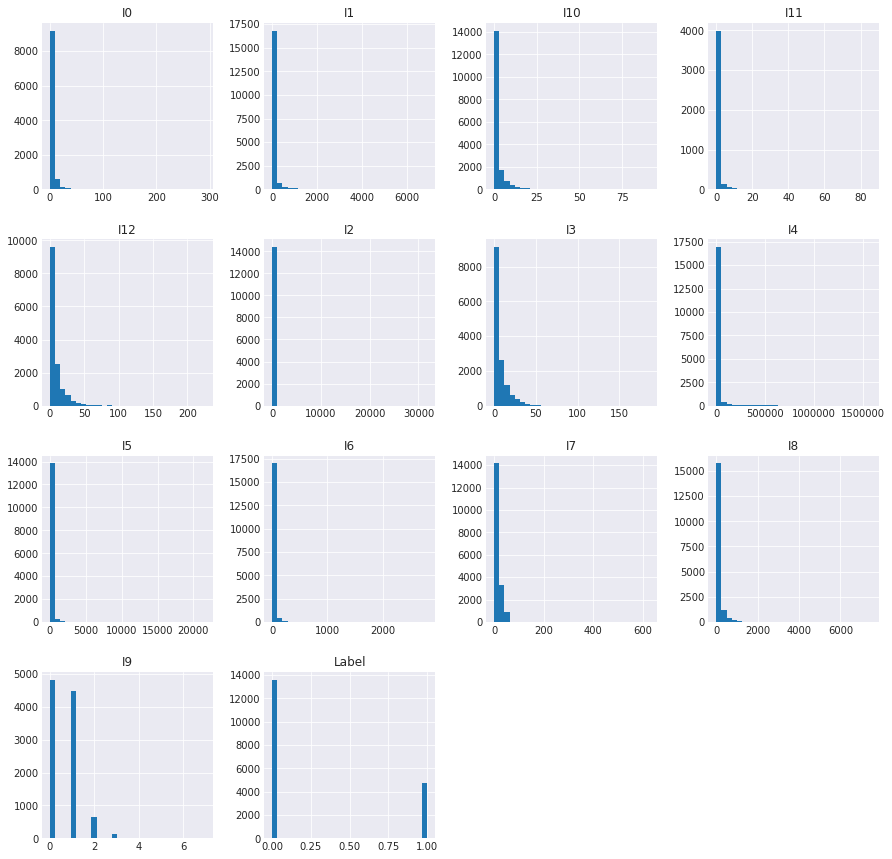

In [53]:
pandaTrain =trainDf.toPandas()
print("\nHistograms for Numeric Values")
plotHist(pandaTrain)

In [64]:
trainDf.dropna().select('Label').describe().show()

+-------+------------------+
|summary|             Label|
+-------+------------------+
|  count|               330|
|   mean|0.3424242424242424|
| stddev|0.4752412940353723|
|    min|                 0|
|    max|                 1|
+-------+------------------+



### Results from EDA on a Sample of Data:

__1. Size of sample__
>22957 rows with 80/20 train, test split. ~18000 in train, ~4600 in test.

__2. Label distribution__
> We have an imbalanced dataset with Label 1 occurring in about 25% of the examples. Thus a simple accuracy score is likely insufficient. In an extreme example where the model did not learn anything and just predict every class as 0, the model would have a very decent accuracy score of 75%. Given imbalance dataset, we would need to evaluate precision and recall as well.

__3. Number of features__
> There are 13 features with numerical values, and 26 features with categorical values.

__4. Numerical features__
> We were told explicitly by the data provider that the first 13 features are numerical values. The median of the features ranges from 1 to 2715, and the mean ranges from 0.72 to 18437. Looking at the description of these features, we notice that the range between minimum and maximum varies greatly, from min - max of 0 - 7 to min-max of 0 - 1585026. Standard deviation ranges from 0.69 to 69831. The histogram above shows that we do not have normal distribution and the distribution is very positively skewed. Since we are using logistic regression, __we need to rescale the numerical variables so that they will have comparable range.__

> Looking at the "TOP OCCURRING CATEGORIES FOR NUMERICAL FEATURES", we notice that the values are all integers. It is possible that these numbers are not continuous variables. They might be ordinal variables. If they were ordinal variables, we do not have information on the ordering of the values nor know whether the numerical values have equidistance (e.g. distance from 1 to 2 is the same as distance from 2 to 3). If we were to treat them as ordinal variables, we would have to use one-hot encoding to create features. Given some of the numerical features have so many unique values (I1, I5 has about 1000, I4 has 8400) it'd be a nightmare for dimensionality. For simplicity sake and also retaining all the values from each feature, we assume they are numerical 
values for now. 

> __Challenges in making it scalable:__
> Normalizing by standard deviation requires calculating mean and standard deviation across node. To make it scalable, we need to map all the sums and counts, and derive mean in the reducer. Once we have the mean value, we need to broadcast it too all the nodes, and map the calculation of deviation from mean and the counts, and derive standard deviation in the reducer. After that, we need to broadcast the mean and standard deviation to all the node to transform each value with standard deviation normalization.

__5. Categorical features__
> For the 26 categorical features, 13 features have more than 1000 unique values, of which 5 features have over 5000 unique values. If we were to one-hot encode every unique values, we would have about 30 million features. 

> Looking at "OCCURENCE COUNT OF TOP 3 MOST FREQUENT VALUES FOR EACH VARIABLE", we see that a few feature have a relatively even distribution across all unique values, while some are highly concentrated in the top few values. For example, for C7, top value has ~11000 count, second most frequent value has 3000 count, third most frequent value has 1400 count. For C8, the respective counts are ~17000, ~1800, 5. It makes sense that some of these variables have long tails. For example, a variable such as which browser the person is using, one would encounter "internet explorer" and "google chrome" as top two categories with probably about 80% of the occurrence, with some long tail for browsers such as Opera, Firefox, etc. Processing 30 million features is computationally expensive and time consuming. We hypothesize that we may not learn so much from the long tail values (such as using Opera vs Firefox) and that we can consider them as one category such as "others". For each categorical feature we only consider top 3 most frequent values and relabel everything else as 'rare'.

> __Challenges in making it scalable:__
> 1. We need to aggregate counts across all nodes to know which are the top 3 values. We need to map all the key and value (counts), and aggregate the counts for each key (unique value) in the reducer. We then sort the key value pair by values, take the top 3 values, and broadcast the list of top 3 values to all nodes. In each node, we compare the values against the top 3 value list. We emit the origin value if its in the top 3 list, or emit 'rare' if it's not in the top 3 list. <br>
> 2. We need to create one-hot encoding columns for each node. While we can independently run one-hot encoding per node, it is potentially problematic if some nodes do not contain all possible values in some columns. For example, one node may only have value 'a123', 'b123', 'c123' as values for column 15, while another node may only have value 'c123', 'd123', 'rare' in column 15. An independent one-hot encoding would create only columns c15_a123, c15_b123, c15_c123 for first node, and only columns c15_c123, c15_d123, c15_rare for the second node. We would have mismatched columns across nodes.<br>
> To address this problem, we need to gather a list of all column values and broadcast it to each node. (The column values are collected in step 1 above). Each node would generate columns using that list of values from step 1. All column values would be set to 0. We can map a function to change the value to 1 if the row has value matches with the column name.

__6. NAs__
> 15 out of 39 features do not have null values. Among the remaining 24, 13 of them have over 3000 null values. 
> As shown in the above cell, if we were to drop any row with NAs, there would be 330 rows left out of ~18000 in training set. i.e. ~98% of rows have some null values in at least one feature. This sounds reasonable for a dataset about internet browsing behavior. We cannot simply drop rows with NAs.
> Without any domain understanding of what those features are, we can only use a very simplistic way to impute some values to fill NAs. For numerical values, we fill NAs with median. For categorical values, we fill NAs with the most frequent values.

> __Challenges in making it scalable:__
> Similar to the above. We need to map key values (counts) and aggregate the counts in reducer to get median. For most frequent values, the step is explained above in 5.2..

__7. Correlation Matrix__
> The below correlation matrix shows that most numerical values do not have high correlation with each other. Thus we are not eliminating any features.


Correlation Matrix between Numeric Values


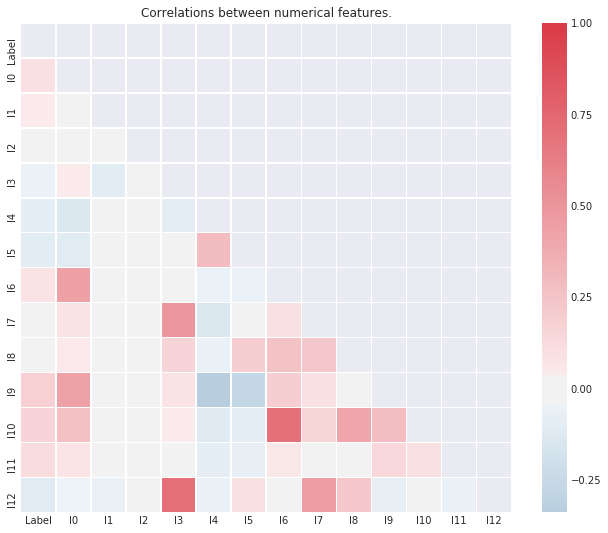

In [51]:
print("\nCorrelation Matrix between Numeric Values")
CorrMatrix(pandaTrain)

#### Running EDA on the full dataset shows similarity of data pattern as observed in the sample above. 

`!python submit_job_to_cluster.py --project_id=w261-222623 --zone=us-central1-b --cluster_name=edacluster --gcs_bucket=w261_final_project --key_file=$HOME/w261.json --create_new_cluster --pyspark_file=loadAndEDA.py --instance_type=n1-standard-16 --worker_nodes=6`

![full_dataset_EDA_1](/full_dataset_EDA_1.png)
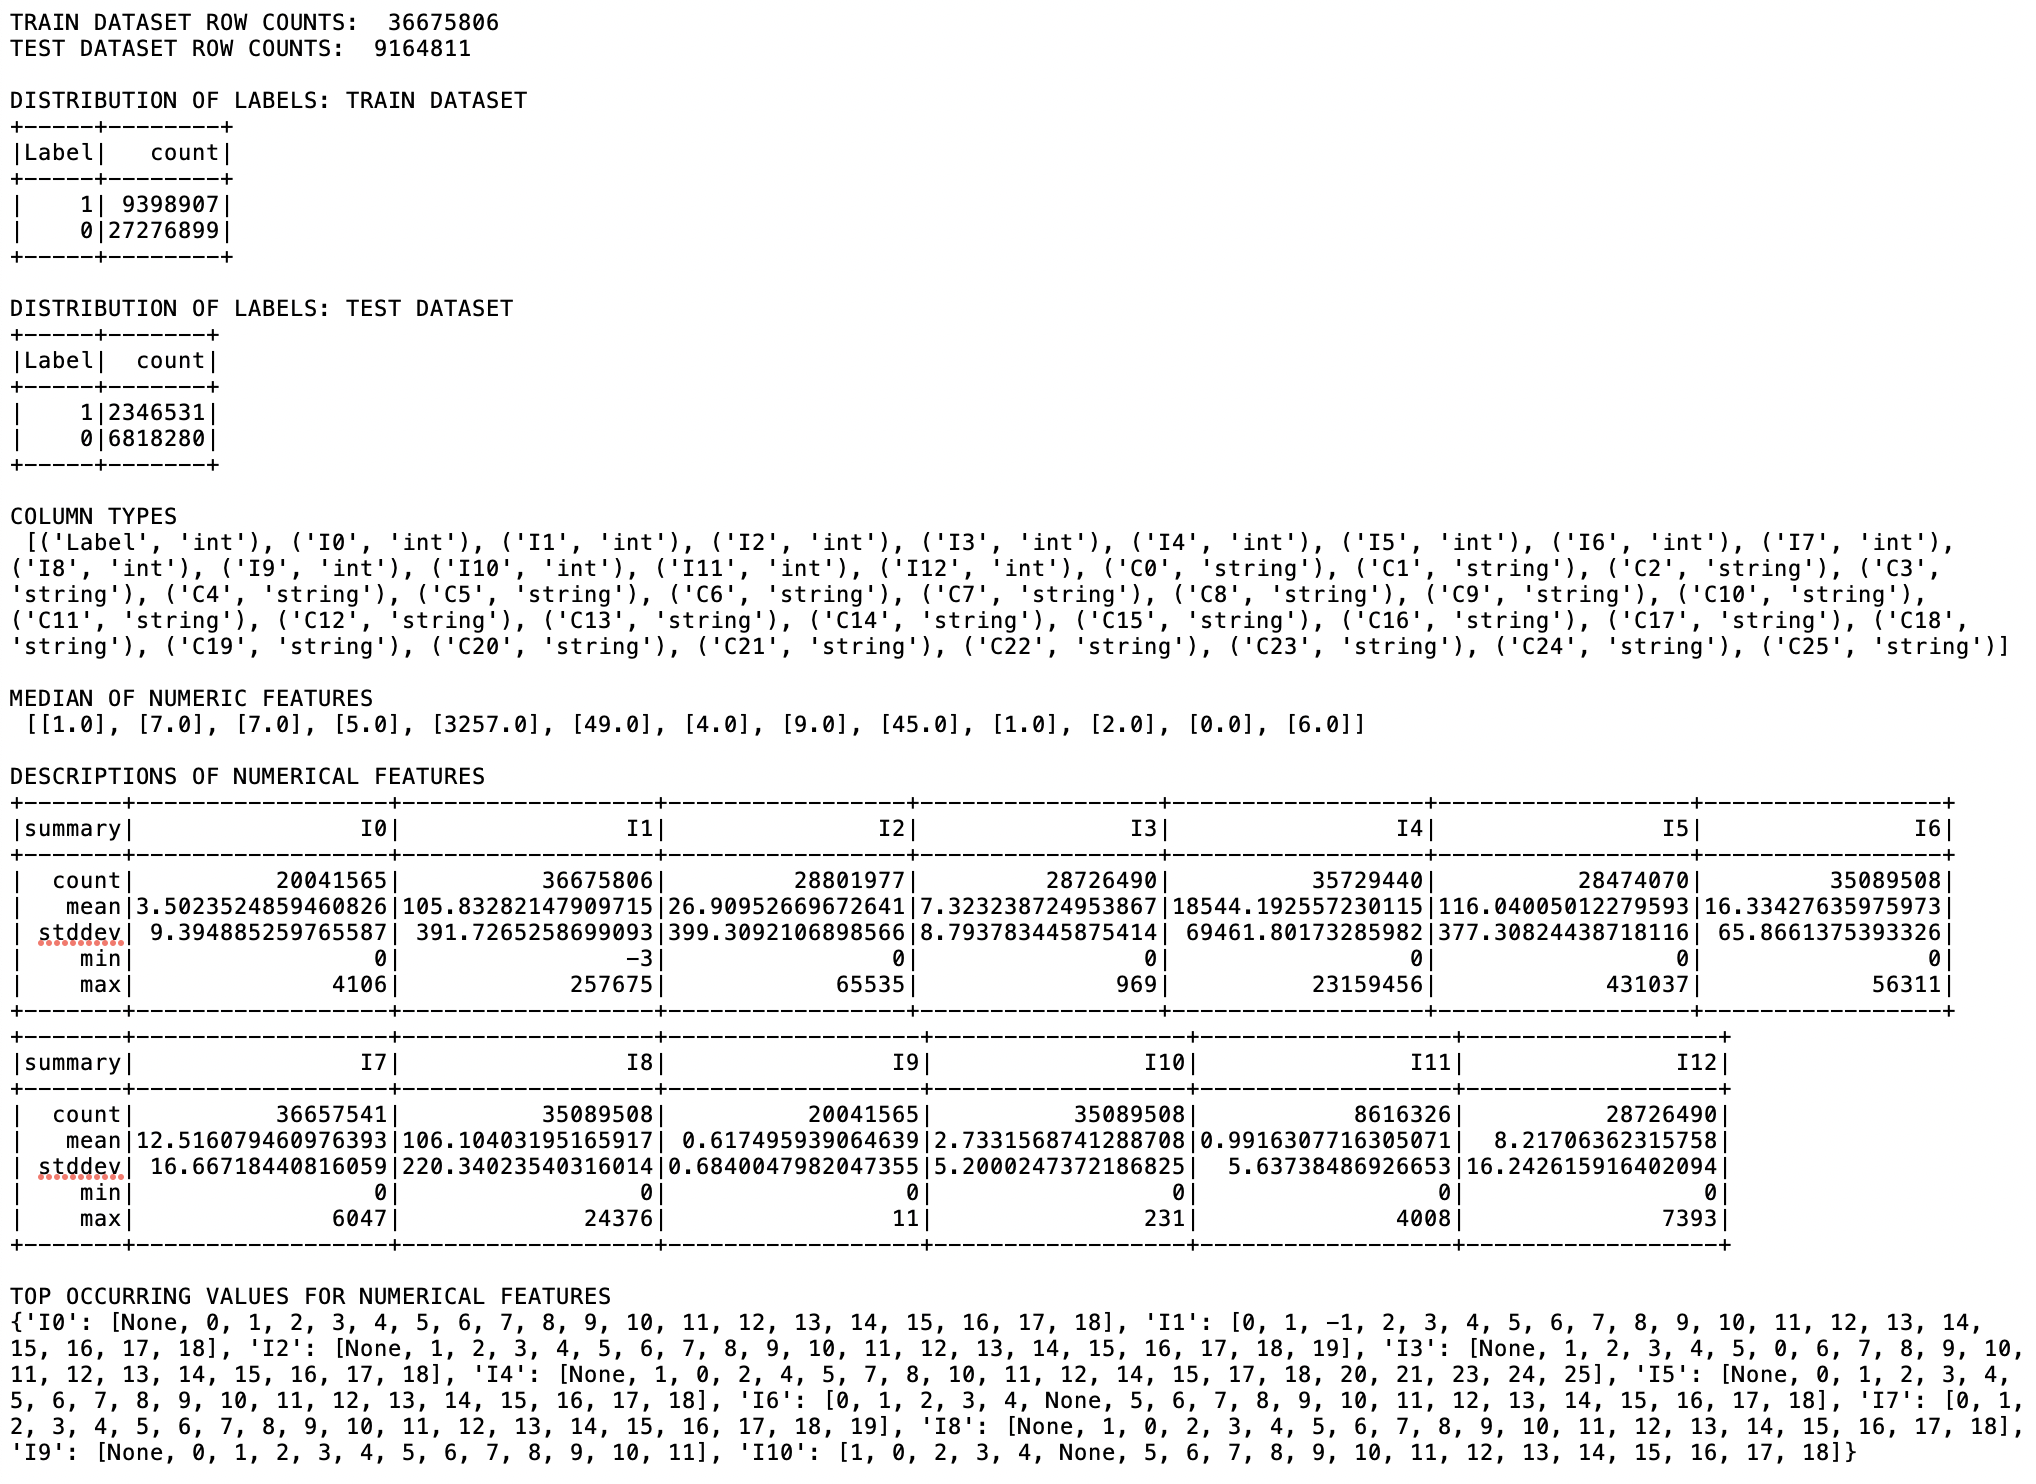

![full_dataset_EDA_2](/full_dataset_EDA_2.png)
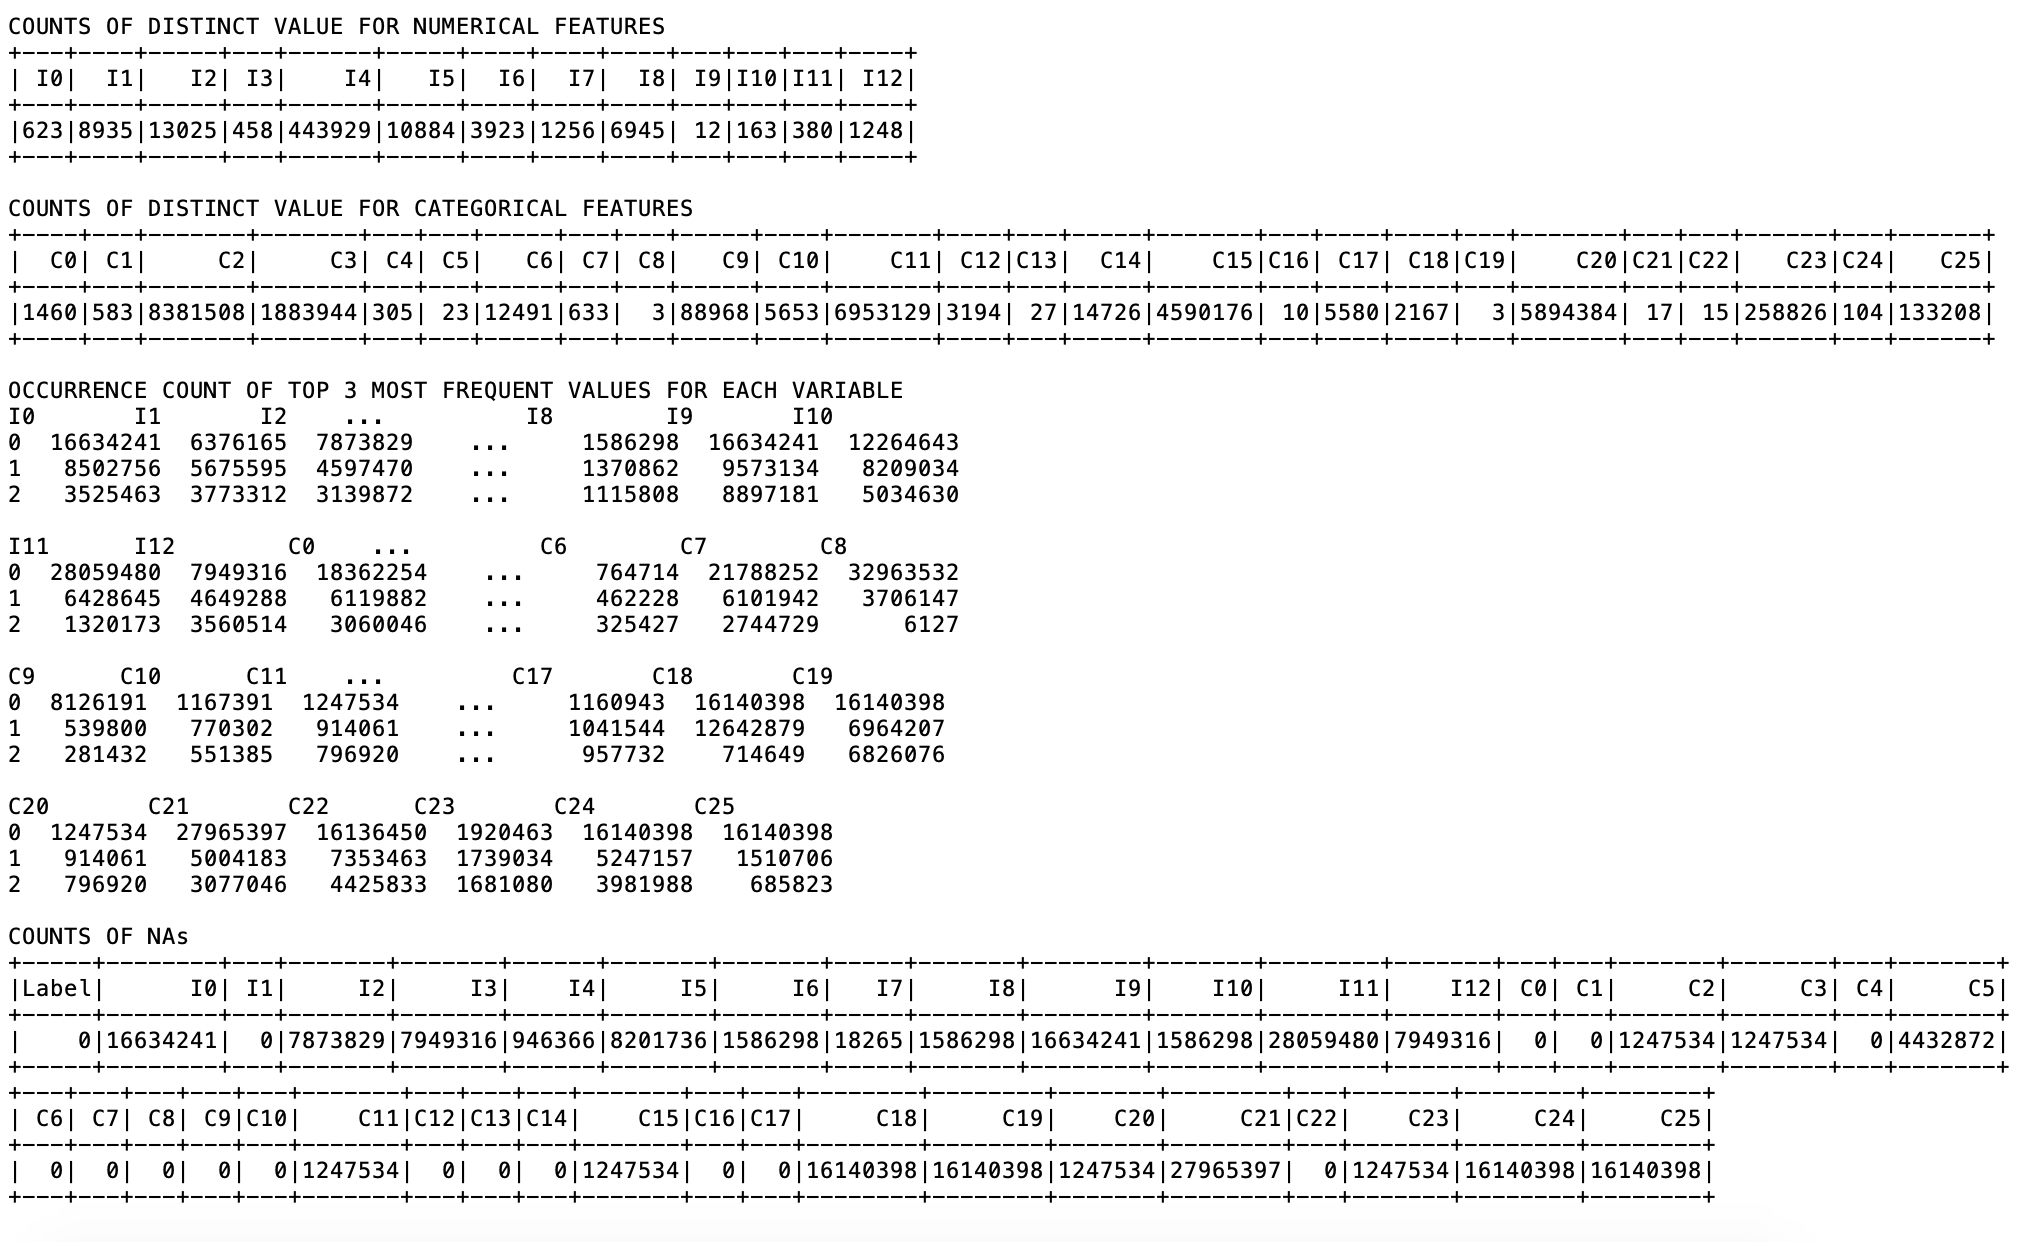

### Algorithm Implementation

In [490]:
%%writefile algorithmImplementation.py
#!/usr/bin/env python

from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, desc, isnan, when
import numpy as np
from operator import add
import copy
import time


MAINCLOUDPATH = 'gs://w261_final_project/train.txt'
MINICLOUDPATH = 'gs://w261_final_project/train_005.txt'
MINILOCALPATH = 'data/train_005.txt'
NUMERICCOLS = 13
CATEGORICALCOLS = 26
NUMERICCOLNAMES = ['I{}'.format(i) for i in range(0,NUMERICCOLS)]
CATCOLNAMES = ['C{}'.format(i) for i in range(0,CATEGORICALCOLS)]
SEED = 2615


# start Spark Session
from pyspark.sql import SparkSession
app_name = "algorithmImplementation"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext


def loadData():
    '''load the data into a Spark dataframe'''
    # select path to data: MAINCLOUDPATH; TOYCLOUDPATH; TOYLOCALPATH
    df = spark.read.csv(path=MAINCLOUDPATH, sep='\t')
    # change column names
    oldColNames = df.columns
    newColNames = ['Label'] + NUMERICCOLNAMES + CATCOLNAMES
    for oldName, newName in zip(oldColNames, newColNames):
        df = df.withColumnRenamed(oldName, newName)
    # change int column types to int from string
    for col in df.columns[:14]:
        df = df.withColumn(col, df[col].cast('int'))
    return df


def splitIntoTestAndTrain(df):
    '''randomly splits 80/20 into training and testing dataframes'''
    splits = df.randomSplit([0.2, 0.8], seed=SEED)
    testDf = splits[0]
    trainDf = splits[1]
    return testDf, trainDf


def getMedians(df, cols):
    '''
    returns approximate median values of the columns given, with null values ignored
    '''
    # 0.5 relative quantile probability and 0.05 relative precision error
    return df.approxQuantile(cols, [0.5], 0.05)


def getMostFrequentCats(df, cols, n):
    '''
    returns a dict where the key is the column and value is an ordered list
    of the top n categories in that column in descending order
    '''
    freqCatDict = {col: None for col in df.columns[cols:]}
    for col in df.columns[cols:]:
        listOfRows = df.groupBy(col).count().sort('count', ascending=False).take(n)
        topCats = [row[col] for row in listOfRows]
        freqCatDict[col] = topCats[:n]
    return freqCatDict
    

def rareReplacer(df, dictOfMostFreqSets):
    '''
    Iterates through columns and replaces non-Frequent categories with 'rare' string.
    '''
    for colName in df.columns[NUMERICCOLS+1:]:
        bagOfCats = dictOfMostFreqSets[colName]
        df = df.withColumn(colName, 
                           udf(lambda x: 'rare' if x not in bagOfCats else x, 
                               StringType())(df[colName])).cache()
    return df

    
def dfToRDD(row):
    '''
    Converts dataframe row to rdd format.
        From: DataFrame['Label', 'I0', ..., 'C0', ...]
        To:   (features_array, y)
    '''    
    features_list = [row['I{}'.format(i)] for i in range(0, NUMERICCOLS)] + \
                        [row['C{}'.format(i)] for i in range(0, CATEGORICALCOLS)]
    features_array = np.array(features_list)
    y = row['Label']
    return (features_array, y)


def emitColumnAndCat(line):
    """
    Takes in a row from RDD and emits a record for each categorical column value 
    along with a zero for one-hot encoding. The emitted values will become a 
    reference dictionary for one-hot encoding in later steps.
        Input: (array([features], dtype='<U21'), 0) or (features, label)
        Output: ((categorical column, category), 0) or (complex key, value)
    The last zero in the output is for initializing one-hot encoding.
    """
    elements = line[0][NUMERICCOLS:]
    for catColName, element in zip(CATCOLNAMES, elements):
        yield ((catColName, element), 0)


def oneHotEncoder(line):
    """
    Takes in a row from RDD and emits row where categorical columns are replaced
    with 1-hot encoded columns.
        Input: (numerical and categorical features, label)
        Output: (numerical and one-hot encoded categorical features, label)
    """
    oneHotDict = copy.deepcopy(bOneHotReference.value)
    elements = line[0][NUMERICCOLS:]
    for catColName, element in zip(CATCOLNAMES, elements):
        oneHotDict[(catColName, element)] = 1
    numericElements = list(line[0][:NUMERICCOLS])
    features = np.array(numericElements + [value for key, value in oneHotDict.items()],
                        dtype=np.float)
    return (features, line[1])


def getMeanAndVar(trainRDD):
    """
    Returns the mean and variance of the training dataset for use in normalizing
    future records (e.g. the test set) to be run on model.
    """
    featureMeans = trainRDD.map(lambda x: x[0]).mean()
    featureStDevs = np.sqrt(trainRDD.map(lambda x: x[0]).variance())
    return featureMeans, featureStDevs
    

def normalize(dataRDD, featureMeans, featureStDevs):
    """
    Scale and center data around the mean of each feature.
    """
    normedRDD = dataRDD.map(lambda x: ((x[0] - featureMeans)/featureStDevs, x[1]))
    return normedRDD


def dataAugmenter(line):
        """
        Adds a 1 value to the array of feature values for the bias term
        """
        return (np.append([1.0], line[0]), line[1])


def logLoss(dataRDD, W):
    """
    Compute log loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(dataAugmenter)
    
    # broadcast the weights
    bW = sc.broadcast(W)
    
    def loss(line):
        loss = np.log(1 + np.exp(-line[1] * np.dot(bW.value, line[0])))
        return loss
    
    losses = augmentedData.map(lambda line: (loss(line), 1)) \
                          .reduce(lambda x,y: (x[0] + y[0], x[1] + y[1]))
    cost = losses[0] / losses[1]
    return cost


def GDUpdateWithReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(dataAugmenter)
    
    # broadcast the weights
    bW = sc.broadcast(W)
    
    # this gets parallelized
    def partialGrad(line):
        return (((1 / (1 + np.exp(-1 * np.dot(bW.value, line[0])))) - line[1]) * line[0])
    
    # reduce to bring it all back together to compute the gradient
    weightedLogProbabilities = augmentedData.map(lambda line: (partialGrad(line), 1)) \
                                            .reduce(lambda x,y: (x[0] + y[0], x[1] + y[1]))
    
    nonRegGrad = weightedLogProbabilities[0]/weightedLogProbabilities[1]
    
    if regType == 'ridge':
        reg = 2*regParam * sum(W[1:])
    elif regType == 'lasso':
        reg = regParam * sum(W[1:]/np.sign(W[1:]))   
    else:
        reg = 0
    grad = nonRegGrad + reg
    
    new_model = W - (grad * learningRate)    
    return new_model


def GradientDescentWithReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    trainHistory, testHistory, modelHistory = [], [], []
    
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdateWithReg(trainRDD, model, learningRate, regType, regParam)
        trainingLoss = logLoss(trainRDD, model) 
        testLoss = logLoss(testRDD, model) 
        
        # keep track of test/train loss for plotting
        trainHistory.append(trainingLoss)
        testHistory.append(testLoss)
        modelHistory.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {trainingLoss}")
            print(f"test loss: {testLoss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return trainHistory, testHistory, modelHistory


def predictionChecker(line):
    """
    line - tuple of (features array including bias, y)
    Takes final model from gradient descent iterations and makes a prediction 
    on the row of test dataset values.
    Returns true positive, false negative, false positive, or true negative
    """
    TP, FN, FP, TN = [0, 0, 0, 0]
    predictionProbability = 1/(1 + np.exp(-1 * np.dot(bModel.value, line[0])))
    if predictionProbability >= 0.5:
        prediction = 1
    else:
        prediction = 0
    if prediction == 1 and line[1] == 1:
        TP = 1
    elif prediction == 0 and line[1] == 1:
        FN = 1
    elif prediction == 1 and line[1] == 0:
        FP = 1
    elif prediction == 0 and line[1] == 0:
        TN = 1
    return (TP, FN, FP, TN)


# load data
df = loadData()
testDf, trainDf = splitIntoTestAndTrain(df)

# get top n most frequent categories for each column (in training set only)
n = 3
mostFreqCatDict = getMostFrequentCats(trainDf, NUMERICCOLS+1, n)

# get dict of sets of most frequent categories in each column for fast lookups during 
# filtering (in later code)
setsMostFreqCatDict = {key: set(value) for key, 
                       value in mostFreqCatDict.items()}

# get the top category from each column for imputation of missing values 
# (in training set only)
fillNADictCat = {key: (value[0] if value[0] is not None else value[1]) for key, 
                 value in mostFreqCatDict.items()}

# get dict of median numeric values for imputation of missing values (in training set only)
fillNADictNum = {key: value for (key, 
                                 value) in zip(trainDf.columns[1:NUMERICCOLS+1], 
                                                    [x[0] for x in getMedians(trainDf,
                                                                              trainDf.columns[1:NUMERICCOLS+1])])}

# impute missing values in training and test set
trainDf = trainDf.na.fill(fillNADictNum) \
                 .na.fill(fillNADictCat)
testDf = testDf.na.fill(fillNADictNum) \
               .na.fill(fillNADictCat)

# replace low-frequency categories with 'rare' string in training and test set
trainDf = rareReplacer(trainDf, setsMostFreqCatDict) # df gets cached in function
testDf = rareReplacer(testDf, setsMostFreqCatDict) # df gets cached in function

# convert dataframe to RDD 
trainRDD = trainDf.rdd.map(dfToRDD).cache()
testRDD = testDf.rdd.map(dfToRDD).cache()
        
# create and broadcast reference dictionary to be used in constructing 1 hot encoded RDD
oneHotReference = trainRDD.flatMap(emitColumnAndCat) \
                          .reduceByKeyLocally(add) # note: only the zero values are being added here 
                                                   # (main goal is to output a dictionary)
bOneHotReference = sc.broadcast(oneHotReference)

# replace rows with new rows having categorical columns 1-hot encoded
trainRDD = trainRDD.map(oneHotEncoder).cache()
testRDD = testRDD.map(oneHotEncoder).cache()

# normalize RDD
featureMeans, featureStDevs = getMeanAndVar(trainRDD)
trainRDD = normalize(trainRDD, featureMeans, featureStDevs).cache()
testRDD = normalize(testRDD, featureMeans, featureStDevs).cache() # use the mean and st. dev. from trainRDD

# create initial weights to train
featureLen = len(trainRDD.take(1)[0][0])
wInit = np.random.normal(size=featureLen+1) # add 1 for bias

# run training iterations
start = time.time()
logLossTrain, logLossTest, models = GradientDescentWithReg(trainRDD, testRDD, wInit, nSteps=500, 
                                                           learningRate = 0.1,
                                                           regType="ridge", regParam=0.001)

# get model accuracy, precision, recall, f1 score
bModel = sc.broadcast(models[-1])
predictionResults = testRDD.map(dataAugmenter) \
                           .map(predictionChecker) \
                           .reduce(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3]))
TP = predictionResults[0]
FN = predictionResults[1]
FP = predictionResults[2]
TN = predictionResults[3]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1Score = 2/((1/recall)+(1/precision))

print("LOG LOSSES OVER TRAINING SET:")
print(logLossTrain)
print("LOG LOSSES OVER TEST SET:")
print(logLossTest)
print("FINAL MODEL:")
print(bModel.value)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")
print("TEST SET ACCURACY:")
print(accuracy)
print("TEST SET PRECISION:")
print(precision)
print("TEST SET RECALL:")
print(recall)
print("TEST SET F1 SCORE:")
print(f1Score)

Overwriting algorithmImplementation.py


#### Illustration of command to run job on Google Cloud Platform cluster

`!python submit_job_to_cluster.py --project_id=w261-222623 --zone=us-central1-b --cluster_name=finalprojectcluster --gcs_bucket=w261_final_project --key_file=$HOME/w261.json --create_new_cluster --pyspark_file=algorithmImplementation.py --instance_type=n1-standard-16 --worker_nodes=6`

#### Results of Google Cloud Platform cluster execution

`... trained 500 iterations in 16138.672616243362 seconds`<br>
`TEST SET ACCURACY:`<br>
`0.7481226873902687`<br>
`TEST SET PRECISION:`<br>
`0.5290065024278094`<br>
`TEST SET RECALL:`<br>
`0.1462423298173223`<br>
`TEST SET F1 SCORE:`<br>
`0.22913965847621373`<br>

The results above show that with the logistic regression model trained on the Criteo dataset, an ad impression event predicted to result in a click will be correct around 53% of the time (precision = 0.529). Of all of the ad impressions that result in real clicks, the model will correctly identify around 14.6% of them (recall = 0.146).

These metrics are low, in part, due to the imbalanced dataset upon which they were trained. More non-click events were present in the training dataset than click events, leading the model to favor predicting non-click events. This is potentially a cost saver for the advertiser, since only the most determined of ad viewers will be identified as ad clickers by the model, thus leading to less ad expenses while obtaining more user purchases, since you're capturing those who are most likely to buy.

Alternatively, with a more balanced dataset, more ad impressions that result in real clicks can be correctly identified.

#### Model Training Losses Displayed
Below is the trend of log losses as the model was trained over the Criteo dataset using the 3 most common categories from each of the categorical columns. The graph shows that 500 iterations was just about enough to reach the (global) minimum of the cost function.

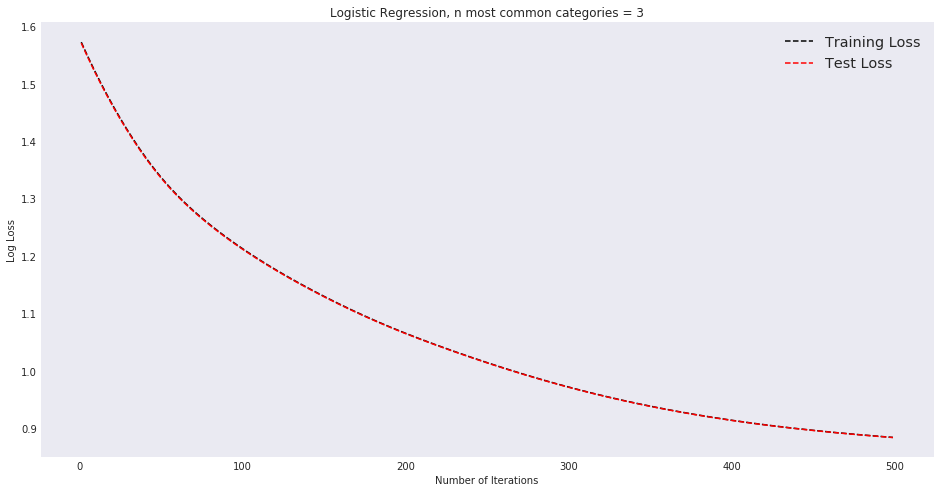

In [1]:
import matplotlib.pyplot as plt

def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of log loss) , testLoss (list of log loss)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()

trainLoss = [1.5787012113535561, 1.5723073156232616, 1.5659893938297644, 1.5597462810329858, 1.5535768364958433, 1.5474799795616592, 1.5414546705752208, 1.535499907911388, 1.5296147223668979, 1.5237981995375063, 1.5180494413162642, 1.5123675682931528, 1.5067517332673732, 1.5012011049296066, 1.4957149157958212, 1.49029244388353, 1.4849329756775673, 1.4796358237412888, 1.4744003216624533, 1.4692258225846728, 1.4641117673045636, 1.45905767333725, 1.4540630020701744, 1.4491272205405494, 1.4442499190608646, 1.4394306262651875, 1.43466872691463, 1.4299637879628884, 1.425315469444809, 1.4207234833851938, 1.4161875520964533, 1.4117074136368781, 1.4072829021079183, 1.4029139015061465, 1.3986002748502713, 1.394341876144385, 1.3901386230464603, 1.3859905227119256, 1.3818976538330765, 1.377860118603312, 1.3738780141456264, 1.3699514453866068, 1.3660805244377978, 1.3622653486088678, 1.3585059938102055, 1.3548025113606015, 1.35115490683714, 1.3475631138782727, 1.3440269768944433, 1.340546249428199, 1.3371205858621449, 1.333749519619518, 1.330432452684038, 1.3271686580177653, 1.3239572796266927, 1.3207973345770896, 1.3176877225451837, 1.3146272395052252, 1.3116145922126958, 1.3086484165888126, 1.3057272938434823, 1.3028497703730249, 1.3000143831241715, 1.2972196746533997, 1.294464200085042, 1.2917465360248452, 1.2890652910325608, 1.2864191124943154, 1.283806690839084, 1.2812267651697151, 1.278678130166966, 1.2761596416649459, 1.2736702192539169, 1.2712088461011752, 1.268774567603475, 1.266366489896782, 1.263983777473093, 1.2616256491819875, 1.2592913736482314, 1.2569802654052487, 1.2546916817630458, 1.252425019902442, 1.2501797137986816, 1.2479552308848327, 1.2457510687024753, 1.2435667517249296, 1.241401828296584, 1.2392558677335201, 1.2371284578778095, 1.2350192032861096, 1.232927723865538, 1.2308536536237547, 1.2287966393714183, 1.2267563393950935, 1.2247324221518714, 1.2227245650414014, 1.2207324533579302, 1.2187557795258908, 1.2167942426099885, 1.2148475479586007, 1.2129154068341177, 1.2109975360066203, 1.2090936574069566, 1.2072034979537896, 1.2053267895715385, 1.2034632692771443, 1.2016126791682047, 1.1997747662458191, 1.1979492821557725, 1.1961359829972957, 1.1943346292952495, 1.192544986138381, 1.1907668234323174, 1.1889999162046223, 1.187244044901439, 1.1854989956259891, 1.1837645602901157, 1.1820405366785878, 1.1803267284537464, 1.1786229451447223, 1.1769290021620165, 1.1752447208530508, 1.1735699285843442, 1.1719044588199732, 1.1702481511725489, 1.1686008514226653, 1.166962411520865, 1.1653326895911833, 1.1637115499454478, 1.1620988631024611, 1.1604945057987366, 1.1588983609799814, 1.1573103177690158, 1.1557302714090367, 1.1541581231810527, 1.1525937802931336, 1.1510371557396348, 1.1494881681306433, 1.14794674149523, 1.1464128050650035, 1.1448862930459014, 1.1433671443848965, 1.1418553025348637, 1.140350715216993, 1.1388533341775007, 1.137363114935626, 1.1358800165219571, 1.1344040012087357, 1.1329350342357751, 1.1314730835361244, 1.1300181194653323, 1.1285701145375209, 1.1271290431708163, 1.1256948814446217, 1.124267606871271, 1.1228471981850798, 1.1214336351518113, 1.1200268984016488, 1.1186269692883921, 1.1172338297769688, 1.1158474623606986, 1.1144678500089589, 1.113094976145225, 1.111728824654641, 1.1103693799197598, 1.109016626882329, 1.1076705511283325, 1.106331138992782, 1.1049983776798555, 1.1036722553930376, 1.1023527614686885, 1.1010398865054825, 1.0997336224806886, 1.0984339628434847, 1.097140902574266, 1.095854438198642, 1.094574567744561, 1.093301290631509, 1.0920346074820058, 1.090774519847337, 1.0895210298422504, 1.0882741396865423, 1.0870338511554891, 1.0858001649451785, 1.0845730799637057, 1.0833525925632426, 1.082138695732606, 1.0809313782730636, 1.0797306239831088, 1.0785364108791258, 1.0773487104792583, 1.076167487176452, 1.0749926977242439, 1.0738242908549671, 1.0726622070453853, 1.07150637843926, 1.0703567289306168, 1.069213174405464, 1.0680756231344417, 1.0669439763037971, 1.0658181286681705, 1.0646979693055596, 1.0635833824528875, 1.0624742483996052, 1.0613704444168626, 1.0602718457005873, 1.0591783263084218, 1.0580897600725396, 1.0570060214728358, 1.0559269864575862, 1.0548525332014234, 1.0537825427930765, 1.0527168998479086, 1.0516554930424147, 1.0505982155700242, 1.0495449655191993, 1.0484956461761872, 1.0474501662561104, 1.0464084400667233, 1.0453703876099765, 1.0443359346267467, 1.0433050125904995, 1.042277558655484, 1.0412535155651685, 1.0402328315262914, 1.0392154600538057, 1.0382013597915007, 1.037190494312908, 1.0361828319066215, 1.0351783453498329, 1.0341770116735014, 1.0331788119221672, 1.0321837309111834, 1.031191756983613, 1.0302028817689013, 1.0292170999450758, 1.028234409005882, 1.0272548090341476, 1.0262783024823148, 1.025304893961016, 1.024334590036217, 1.0233673990354544, 1.022403330863455, 1.0214423968273554, 1.02048460947155, 1.0195299824222475, 1.0185785302415762, 1.0176302682911547, 1.0166852126048795, 1.0157433797706947, 1.0148047868210694, 1.0138694511318607, 1.0129373903292231, 1.012008622204207, 1.0110831646346803, 1.0101610355142259, 1.0092422526876015, 1.0083268338923905, 1.007414796706527, 1.0065061585012485, 1.005600936399206, 1.004699147237299, 1.0038008075339764, 1.002905933460647, 1.0020145408168795, 1.0011266450091334, 1.000242261032722, 0.9993614034567173, 0.9984840864115951, 0.997610323579331, 0.9967401281857855, 0.9958735129950772, 0.9950104903058409, 0.994151071949123, 0.9932952692877719, 0.992443093217129, 0.9915945541669359, 0.9907496621042212, 0.9899084265371295, 0.9890708565195446, 0.9882369606563363, 0.9874067471092468, 0.9865802236032072, 0.9857573974331006, 0.9849382754707825, 0.9841228641724238, 0.9833111695859841, 0.9825031973588481, 0.9816989527455172, 0.980898440615366, 0.9801016654603423, 0.9793086314026758, 0.9785193422024694, 0.9777338012652156, 0.9769520116491638, 0.9761739760725447, 0.9753996969206512, 0.9746291762527116, 0.9738624158085867, 0.9730994170152472, 0.9723401809930851, 0.9715847085619644, 0.9708330002470975, 0.97008505628466, 0.969340876627225, 0.9686004609489685, 0.9678638086506328, 0.9671309188643312, 0.9664017904580753, 0.9656764220401631, 0.9649548119633116, 0.9642369583286242, 0.9635228589893735, 0.9628125115545833, 0.9621059133924303, 0.9614030616335207, 0.9607039531739424, 0.9600085846782135, 0.9593169525820526, 0.9586290530950441, 0.9579448822031206, 0.9572644356709828, 0.9565877090443409, 0.955914697652098, 0.9552453966084038, 0.9545798008146175, 0.9539179049611847, 0.9532597035294409, 0.9526051907933201, 0.9519543608210218, 0.9513072074765972, 0.9506637244214818, 0.9500239051159833, 0.949387742820735, 0.9487552305980829, 0.9481263613134628, 0.9475011276367445, 0.9468795220435496, 0.9462615368165496, 0.9456471640467441, 0.9450363956347574, 0.9444292232920778, 0.9438256385423476, 0.9432256327226293, 0.9426291969846666, 0.9420363222961801, 0.9414469994421631, 0.9408612190261707, 0.9402789714716767, 0.9397002470233952, 0.9391250357486678, 0.9385533275388469, 0.9379851121107231, 0.9374203790079806, 0.9368591176026696, 0.9363013170967314, 0.9357469665235474, 0.9351960547495157, 0.9346485704756896, 0.9341045022394223, 0.9335638384160745, 0.9330265672207589, 0.9324926767101224, 0.9319621547841644, 0.9314349891880951, 0.9309111675142626, 0.9303906772040904, 0.9298735055500807, 0.9293596396978522, 0.9288490666482028, 0.9283417732592736, 0.9278377462486792, 0.927336972195751, 0.9268394375437594, 0.9263451286022472, 0.9258540315493339, 0.9253661324341225, 0.9248814171790999, 0.9243998715826112, 0.9239214813213427, 0.9234462319528707, 0.9229741089182376, 0.9225050975445348, 0.9220391830475659, 0.9215763505345222, 0.9211165850066759, 0.9206598713621236, 0.9202061943985473, 0.919755538816013, 0.9193078892197825, 0.9188632301231524, 0.9184215459503163, 0.9179828210392564, 0.9175470396446387, 0.9171141859407349, 0.9166842440243445, 0.9162571979177634, 0.9158330315717212, 0.9154117288683656, 0.9149932736242199, 0.9145776495931822, 0.9141648404695109, 0.9137548298907878, 0.9133476014409394, 0.9129431386531957, 0.9125414250130955, 0.9121424439614532, 0.9117461788973195, 0.9113526131809844, 0.9109617301368709, 0.9105735130565319, 0.9101879452015377, 0.9098050098064154, 0.9094246900815283, 0.9090469692159551, 0.9086718303803466, 0.9082992567297745, 0.9079292314065199, 0.9075617375428823, 0.9071967582639354, 0.9068342766902516, 0.9064742759406407, 0.9061167391347905, 0.905761649395938, 0.9054089898534728, 0.9050587436455454, 0.9047108939215707, 0.9043654238447874, 0.9040223165947056, 0.9036815553695711, 0.9033431233887489, 0.9030070038951034, 0.9026731801573228, 0.902341635472201, 0.902012353166893, 0.9016853166011108, 0.9013605091692957, 0.9010379143027514, 0.9007175154716932, 0.900399296187333, 0.9000832400038273, 0.8997693305202746, 0.8994575513825885, 0.8991478862853911, 0.8988403189738169, 0.8985348332453076, 0.8982314129513309, 0.897930041999101, 0.8976307043532024, 0.8973333840371982, 0.897038065135212, 0.8967447317934213, 0.8964533682215634, 0.8961639586943445, 0.8958764875528451, 0.8955909392058712, 0.8953072981312502, 0.895025548877121, 0.8947456760631384, 0.8944676643816717, 0.894191498598941, 0.8939171635561394, 0.8936446441704854, 0.8933739254362479, 0.8931049924257615, 0.8928378302903544, 0.8925724242612565, 0.8923087596505244, 0.8920468218518242, 0.8917865963412849, 0.8915280686782405, 0.89127122450598, 0.8910160495524606, 0.8907625296309584, 0.8905106506407134, 0.8902603985675408, 0.8900117594843946, 0.8897647195519149, 0.8895192650189576, 0.8892753822230354, 0.8890330575907976, 0.8887922776384659, 0.8885530289722107, 0.8883152982885201, 0.8880790723745458, 0.8878443381084223, 0.8876110824595467, 0.8873792924888606, 0.8871489553490632, 0.8869200582848479, 0.8866925886330803, 0.8864665338229715, 0.8862418813762256, 0.8860186189071607, 0.8857967341228107, 0.8855762148230015, 0.8853570489004196, 0.8851392243406457, 0.8849227292221805, 0.8847075517164364]
testLoss = [1.5770905268111706, 1.5707048292093126, 1.5643949428474166, 1.5581597415561348, 1.5519981262223967, 1.5459090615921895, 1.5398915523508006, 1.533944640067131, 1.5280673705483858, 1.5222588031317197, 1.5165180211414653, 1.5108441507384405, 1.5052363506019897, 1.4996938004055502, 1.494215736892781, 1.4888014318896587, 1.4834501698773155, 1.4781612643335933, 1.4729341160101668, 1.4677680303010756, 1.4626623617460734, 1.4576165919988344, 1.4526301927744532, 1.4477026143718565, 1.442833329939756, 1.4380219073227776, 1.4332678052765297, 1.4285706477488507, 1.4239301557526083, 1.4193460509199824, 1.4148180073783865, 1.4103457180486278, 1.4059289717376389, 1.4015676369953975, 1.3972615805929436, 1.3930106884186315, 1.3888149267770697, 1.3846743572343432, 1.3805891097460112, 1.3765593094708675, 1.3725850365635082, 1.3686663672260289, 1.364803394067879, 1.36099620114023, 1.3572448446651897, 1.3535493523954767, 1.3499097133823934, 1.3463258563339218, 1.3427976288814067, 1.33932479096117, 1.3359070029004196, 1.3325438033397417, 1.3292345905846035, 1.325978616647685, 1.322774993730245, 1.3196227103397795, 1.316520649679794, 1.313467603350082, 1.3104622815233724, 1.307503326836383, 1.3045893276257707, 1.3017188308995395, 1.2988903627753783, 1.2961024504999932, 1.2933536396134406, 1.290642504828308, 1.2879676584157747, 1.285327756543857, 1.2827215015686855, 1.2801476444979403, 1.277604990467153, 1.2750924047910015, 1.2726088160210705, 1.2701532154708182, 1.2677246549304138, 1.2653222435487779, 1.2629451454186913, 1.2605925784369114, 1.2582638124277392, 1.2559581657534458, 1.2536750012691118, 1.2514137222323407, 1.249173768330795, 1.2469546118912438, 1.2447557543243197, 1.2425767227588926, 1.2404170668703645, 1.2382763562242252, 1.2361541784868275, 1.2340501382679774, 1.2319638559535457, 1.2298949662016938, 1.2278431162496077, 1.2258079643052093, 1.2237891782020673, 1.2217864344166218, 1.2197994174838152, 1.217827819725358, 1.2158713410653603, 1.2139296886580992, 1.212002576167331, 1.210089722790976, 1.2081908523578386, 1.2063056928222047, 1.204433976214452, 1.202575438826605, 1.2007298213749147, 1.1988968690424955, 1.1970763314620374, 1.1952679627436502, 1.1934715216072216, 1.1916867716151023, 1.1899134814666636, 1.1881514253078278, 1.186400383011838, 1.1846601404000803, 1.1829304893900987, 1.1812112280747697, 1.1795021607479377, 1.1778030978978247, 1.176113856189334, 1.1744342584488423, 1.1727641336534804, 1.1711033169188263, 1.1694516494789442, 1.1678089786590486, 1.1661751578481734, 1.1645500464814935, 1.162933510036884, 1.1613254200409633, 1.1597256540731153, 1.1581340957558601, 1.156550634724304, 1.1549751665726073, 1.1534075927786687, 1.1518478206089637, 1.1502957630043102, 1.148751338445141, 1.1472144707939138, 1.1456850891129995, 1.144163127458681, 1.1426485246539597, 1.141141224043436, 1.1396411732328653, 1.1381483238150125, 1.136662631083319, 1.1351840537358409, 1.1337125535734272, 1.1322480951972442, 1.1307906457113905, 1.1293401744359783, 1.1278966526354208, 1.1264600532654259, 1.1250303507412138, 1.1236075207283311, 1.122191539956761, 1.1207823860585417, 1.1193800374290295, 1.117984473112196, 1.1165956727106292, 1.1152136163213067, 1.1138382844982322, 1.1124696582428353, 1.1111077190225256, 1.109752448816926, 1.108403830190382, 1.1070618463882063, 1.1057264814530783, 1.104397720356869, 1.1030755491421174, 1.1017599550662547, 1.1004509267405886, 1.0991484542550136, 1.097852529278471, 1.0965631451243283, 1.0952802967695447, 1.0940039808162947, 1.092734195385424, 1.091470939932163, 1.0902142149764633, 1.0889640217428531, 1.0877203617078643, 1.086483236056928, 1.0852526450566582, 1.0840285873529207, 1.082811059209386, 1.08160005370536, 1.0803955599152417, 1.0791975620945686, 1.0780060388993422, 1.0768209626655256, 1.0756422987747063, 1.074470005129482, 1.0733040317585607, 1.0721443205669479, 1.070990805241221, 1.0698434113142108, 1.0687020563875445, 1.0675666505050876, 1.0664370966653471, 1.065313291456822, 1.064195125797147, 1.0630824857547285, 1.0619752534305718, 1.060873307877824, 1.0597765260373573, 1.0586847836692266, 1.0575979562617643, 1.0565159199025587, 1.0554385520981724, 1.0543657325321012, 1.0532973437532511, 1.0522332717896128, 1.0511734066842127, 1.050117642952472, 1.0490658799618122, 1.0480180222358808, 1.0469739796869133, 1.0459336677806446, 1.0448970076388406, 1.0438639260848968, 1.0428343556382356, 1.0418082344631956, 1.0407855062781204, 1.0397661202301003, 1.0387500307405921, 1.0377371973268263, 1.036727584403523, 1.0357211610691048, 1.0347179008801857, 1.0337177816177316, 1.032720785047922, 1.0317268966804096, 1.0307361055262882, 1.0297484038578064, 1.0287637869715633, 1.0277822529566172, 1.0268038024687718, 1.0258284385119834, 1.0248561662277087, 1.0238869926928185, 1.0229209267265034, 1.0219579787065185, 1.0209981603949414, 1.0200414847735613, 1.0190879658888712, 1.0181376187066011, 1.0171904589756475, 1.016246503101208, 1.0153057680268536, 1.0143682711252893, 1.0134340300974733, 1.012503062879746, 1.011575387558675, 1.0106510222931788, 1.0097299852436041, 1.0088122945073985, 1.0078979680609557, 1.0069870237073122, 1.0060794790293053, 1.0051753513478578, 1.004274657685029, 1.0033774147315122, 1.0024836388182454, 1.0015933458918502, 1.0007065514935838, 0.9998232707415216, 0.998943518315737, 0.9980673084461774, 0.997194654903057, 0.996325570989477, 0.9954600695361133, 0.9945981628977522, 0.9937398629514861, 0.9928851810964001, 0.9920341282545916, 0.991186714873359, 0.9903429509284423, 0.9895028459281484, 0.9886664089182893, 0.987833648487782, 0.9870045727748241, 0.9861791894735571, 0.9853575058411214, 0.9845395287050381, 0.9837252644708228, 0.9829147191298009, 0.9821078982670389, 0.9813048070693504, 0.9805054503333286, 0.9797098324733801, 0.9789179575296799, 0.9781298291760732, 0.9773454507278516, 0.976564825149392, 0.9757879550616664, 0.9750148427495332, 0.9742454901688945, 0.973479898953612, 0.9727180704222461, 0.9719600055845542, 0.9712057051477919, 0.9704551695227683, 0.969708398829695, 0.9689653929037962, 0.9682261513006986, 0.9674906733015916, 0.9667589579181827, 0.9660310038974055, 0.9653068097259527, 0.9645863736345691, 0.9638696936021675, 0.963156767359726, 0.9624475923940173, 0.9617421659511498, 0.9610404850399146, 0.9603425464350015, 0.9596483466800197, 0.9589578820903961, 0.9582711487561014, 0.9575881425442622, 0.9569088591016301, 0.9562332938569377, 0.9555614420231408, 0.9548932985995428, 0.9542288583738331, 0.9535681159240335, 0.9529110656203482, 0.9522577016269453, 0.9516080179036757, 0.9509620082076947, 0.9503196660950615, 0.94968098492227, 0.9490459578477255, 0.948414577833191, 0.9477868376451957, 0.9471627298564052, 0.946542246846966, 0.9459253808058528, 0.9453121237321513, 0.9447024674363783, 0.9440964035417557, 0.9434939234855093, 0.942895018520136, 0.9422996797147112, 0.9417078979561626, 0.941119663950589, 0.9405349682245701, 0.9399538011264954, 0.9393761528279209, 0.9388020133249414, 0.9382313724395764, 0.9376642198212, 0.937100544947991, 0.9365403371284033, 0.9359835855026843, 0.9354302790444136, 0.9348804065620895, 0.9343339567007355, 0.933790917943559, 0.9332512786136413, 0.9327150268756673, 0.9321821507377015, 0.931652638052998, 0.9311264765218543, 0.9306036536935118, 0.9300841569680927, 0.9295679735985888, 0.9290550906928806, 0.9285454952158134, 0.9280391739913051, 0.927536113704511, 0.9270363009040055, 0.9265397220040443, 0.9260463632868378, 0.9255562109048723, 0.925069250883279, 0.9245854691222429, 0.9241048513994438, 0.9236273833725398, 0.9231530505816868, 0.9226818384521019, 0.9222137322966429, 0.9217487173184387, 0.9212867786135571, 0.9208279011736732, 0.9203720698888057, 0.9199192695500551, 0.9194694848523762, 0.9190227003973799, 0.9185789006961508, 0.9181380701720928, 0.9177001931637903, 0.917265253927886, 0.9168332366419906, 0.9164041254075783, 0.915977904252923, 0.9155545571360263, 0.9151340679475738, 0.914716420513877, 0.9143015985998327, 0.9138895859118901, 0.9134803661010056, 0.913073922765615, 0.912670239454595, 0.9122692996702101, 0.9118710868710801, 0.9114755844751165, 0.9110827758624651, 0.9106926443784286, 0.9103051733363854, 0.9099203460206917, 0.9095381456895608, 0.909158555577932, 0.9087815589003384, 0.9084071388537146, 0.9080352786202148, 0.9076659613700084, 0.9072991702640231, 0.906934888456706, 0.9065730990987046, 0.9062137853395777, 0.9058569303304242, 0.90550251722652, 0.9051505291898998, 0.9048009493919231, 0.9044537610157887, 0.9041089472590293, 0.9037664913359662, 0.9034263764801244, 0.9030885859466118, 0.9027531030144658, 0.9024199109889557, 0.9020889932038394, 0.9017603330235993, 0.9014339138456207, 0.9011097191023294, 0.900787732263307, 0.9004679368373354, 0.9001503163744242, 0.8998348544677868, 0.8995215347557639, 0.8992103409237231, 0.8989012567058994, 0.8985942658872048, 0.8982893523049846, 0.8979864998507362, 0.8976856924717846, 0.897386914172911, 0.897090149017948, 0.8967953811313154, 0.8965025946995349, 0.8962117739726807, 0.8959229032658037, 0.8956359669603079, 0.8953509495052847, 0.895067835418807, 0.8947866092891807, 0.8945072557761565, 0.8942297596121123, 0.8939541056031686, 0.8936802786302982, 0.893408263650369, 0.8931380456971669, 0.8928696098823752, 0.8926029413965081, 0.8923380255098186, 0.8920748475731726, 0.8918133930188717, 0.8915536473614583, 0.8912955961984647, 0.891039225211163, 0.8907845201652322, 0.8905314669114439, 0.8902800513862792, 0.8900302596125267, 0.8897820776998533, 0.8895354918453338, 0.8892904883339531, 0.8890470535390991, 0.8888051739229871, 0.8885648360370918, 0.8883260265225328, 0.8880887321104426, 0.887852939622293, 0.8876186359702187, 0.8873858081572875, 0.8871544432777755, 0.8869245285173871, 0.8866960511534796, 0.8864689985552402, 0.8862433581838562, 0.8860191175926603, 0.8857962644272454, 0.8855747864255661, 0.8853546714180197, 0.8851359073275049, 0.8849184821694545, 0.88470238405186, 0.8844876011752705]
plotErrorCurves(trainLoss, testLoss, title = 'Logistic Regression, n most common categories = 3' )

### 5. Application of Course Concepts

#### 5.1  Normalization
Data is normalized to create independence in the scales and ranges of features. For example, one might consider normalizing a dataset with the features 'years employed' and 'salary' because years employed has a range from 0 to 30 and salary ranges from 10,000 to 500,000. The wider range of salary might overshadow contributions of years employed.  Once the data is normalized, it has the benefit of being unit neutural. That is, years can be compared to dollars in an apples to apples way.  We chose to normalize the data of all features because some columns had immense ranges compared to other columns.  The contributions of the one hot encoded columns and other features with small ranges would be overshadowed.   Further, we did not know what units were used to measure the features (or if they were even measurable). We chose to standardize the data using the z score: $x_n= (x - \mu)/\sigma$ where $\mu$ is the mean value and $\sigma$ is the standard deviation. This figure expresses the number of standard deviations from the mean an x value is. It casts each datum as a magnitude against the feature set's own statistical characteristics.

Another benefit of normalization is better performance of gradient descent, at least anecdotely. This is most obvious in a linear regression.  Consider a graph minimizing the loss function for the salary/years regression discussed earlier. The graph of the coeficients $\theta_{1}$ and $\theta_{2}$ would be concentric elipses. However the elipses would be extremely elongated and have an aspect ratio of year_range/salary_range (or 30/490000). Extreme surface changes will increase the number of gradients. Now consider standardizing the values using a z score. Most of the data will fall between 3 standard deviations from the mean. 

#### 5.2  One Hot Encoding
One Hot Encoding is a technique used to convert categorical data into numeric data. This is a useful and often essential task in data preperation because many classification and regression methods, logistic regression included, require all features to be in numeric form.

In order to encode a feature, you first must identify all the unique categories. This requires all the categories of a feature to be shared among all machines in the cluster. The categorical feature is removed and the data structure is expanded to add new columns (features) for each category. A '1' or '0' value is placed in each column acording to the original value of the category. For example, the second data set is a one hot encoded version of the first.

|count|fruit  |
|-----|----------|
|10   |bannana|
|5    |apple  |
|20   |orange|
|12   |orange|
|15   |bannana|


|count|bannana  | apple |orange|
|-----|---------|-------|------|
|10   |1        | 0     |  0   |
|5    |0        | 1     |  0   |
|20   |0        | 0     |  1   |
|12   |0        | 0     |  1   |
|15   |1        | 0     |  0   |


For toy data sets this representation is workable, however for large datasets like ours there are tradeoffs to consider. In our small data set, among all the categorical features, there are about 72000 unique values. In the large dataet there were over 30 milion. We observed that there were more columns than rows. If every category is promoted in importance to be represented by its own coefficient in the regression, there would probably not be enough data and more important contributers would be crowded out. Our team avoided this by only using the top 3 categories per feature.

Also troubling is the task of loading and storing in this format. It would create an explosion in size that would consume resources and slow down development and debugging. Say goodbye to head(5) with 72000, let alone 30m, additional columns! If you could even load the structure into memory.

Thankfully, PySpark.ml provides striped representation of the data. Stripes is a more dense representation for one hot encoded features because the 0 values are not actually stored, but presumed to be default. Instead of creating new columns for each new category-feature, the Spark OneHotEncoderEstimator will produce a single column with values representing the entire row of categorical data. For example, using this dense representation on the original count/fruit table yields:

|count|fruit  |
|-----|----------|
|10   |(3,[0],[1])|
|5    |(3,[1],[1])  |
|20   |(3,[2],[1])|
|12   |(3,[2],[1])|
|15   |(3,[0],[1])|

where each item is a tupple in the form (NUM,[POS],[VAL])
Where NUM is the number of columns (features) in the one hot encode, POS is the position of the feature in the row, and VAL is the value of the feature.  For example, the first row (3,[0],[1]) translates to 3 columns total, with a 1 in position 0 in this row.  Which is equivilant to:

|count|bannana  | apple |orange|
|-----|---------|-------|------|
|10   |1        | 0     |  0   |


Naturally, this dense representation works well in the Spark.ml API ecosystem.  Having implemented a homegrown version of logistic regression, we  implemented a homegrown version of one hot encoding as well, in our logloss and gdupdate methods.  The PySpark.ml representation would probably have sped things up by minimizing data moving on the network, memory utilization, and maybe even disk swaping.  

#### 5.4  Scaleability
Had it not been for cloud based comodity hardware, there would be no MIDS program, and little data science. It makes big things possible, but it is not a cure all for bad programming habits.  Maybe you've heard of Wirth's law regarding software bloat.  'Software expands to fill all new resources', 'Software gets slower more rapidly than hardware becomes faster' are a few forms.  Having more computing power at our fingertips makes abuse easier.

Consider the above example, one hot encoding.  It is very easy to be lulled into thinking that one hot encoding the whole dataset would be a workable part of the solution.  Thankfully we caught it before we tried to implement it.

But far from relieving programmers from thinking about scaleability, programming in this environment makes you very conscious of it in a way that you don't have to be when programming on a single machine.  For example map() and flatMap()s are narrow transformations.  They can work with data in the local partition.  Our code does that 15 times. The 4 reduces are wide transformations that require a shuffle.  Even though reduce is done strategically, it is sometime not avoidable:

Occurances of Reduce:
In GDUpdateWithReg, this is most expensive because it occurs once per iteration.

To calculate predictionResults.  This only occurs once per execution.

To calculate LogLoss:  Unfortunately, this is done twice per iteration.  We could have executed it a few times for the whole execution.

